# Praktická statistika - 3. domácí úkol

## Modelování HDP

In [ ]:
.libPaths("../libs")
library(ggplot2)
library(dplyr)
library(eurostat)
library(lmtest)
library(MASS)
library(car)

In [3]:
data <- get_eurostat('nama_10_pc')

head(data)

Table nama_10_pc cached at /tmp/Rtmpi26MSj/eurostat/0147ca6e479f1adc98d26eab474b6847.rds



freq,unit,na_item,geo,TIME_PERIOD,values
<chr>,<chr>,<chr>,<chr>,<date>,<dbl>
A,CLV10_EUR_HAB,B1GQ,AL,1995-01-01,1310
A,CLV10_EUR_HAB,B1GQ,AL,1996-01-01,1410
A,CLV10_EUR_HAB,B1GQ,AL,1997-01-01,1270
A,CLV10_EUR_HAB,B1GQ,AL,1998-01-01,1390
A,CLV10_EUR_HAB,B1GQ,AL,1999-01-01,1580
A,CLV10_EUR_HAB,B1GQ,AL,2000-01-01,1700


vyfiltrování data podle zadání:

In [4]:
data = data[data$unit == "CP_EUR_HAB", ]
data = data[data$na_item == "B1GQ", ]
data = data[data$TIME_PERIOD == as.Date("2020-01-01"), ]
data <- data[!grepl("^(EU|EA)", data$geo), ]

data$TIME_PERIOD = NULL
data$freq = NULL
data$unit = NULL
data$na_item = NULL

head(data)

geo,values
<chr>,<dbl>
AL,4690
AT,42720
BE,39910
BG,8880
CH,75330
CY,24760


HDP je celková peněžní hodnota prodktů a služeb nově vytvořená za daný rok na daném území. My máme modelovat HDP v přepočtu na jednoho obyvatele.

Myslím si, že velký vliv bude mít na HDP průměrné výdaje jednoho obyvatele daného území - lidé jsou koneční uživatelé a domácí výroba bude vysoce korelovaná s tím kolik toho lidé na daném územé utratí.

Druhým důležitým "spotřebitelem" je vláda. Vezmu si tedy výdaje vlády přepočítané na jednoho obyvatele v daném období.

Myslím si, že inflace by také mohla ovlivňovat velikost HDP, takže třetím spojitým regresorem bude inflace.

Jako kategorický regres si vezmeme, zda daná země platí eurem. Myslím si, že země, které budou mít euro budou mít výrazně vyšší HDP na obyvatele, takže to prozkoumáme.

## Výdaje obyvatele

https://ec.europa.eu/eurostat/databrowser/view/hbs_exp_t111/default/table?lang=en

obsahují všechny tyto výdaje:

    CP01              Food and non-alcoholic beverages
    CP02              Alcoholic beverages, tobacco and narcotics
    CP03              Clothing and footwear
    CP04              Housing, water, electricity, gas and other fuels
    CP05              Furnishings, household equipment and routine maintenance of the house
    CP06              Health
    CP07              Transport
    CP08              Communications
    CP09              Recreation and culture
    CP10              Education
    CP11              Restaurants and hotels
    CP12              Miscellaneous goods and services


V závislosti na zemi obsahují/neobsahují náklady na bydlení, například v ČR je neobsahují.

In [5]:
con <- get_eurostat("hbs_exp_t111")

head(con)

con <- con[con$unit == "EUR_AE", ] # euro expenditure per capita
con <- con[con$TIME_PERIOD == as.Date("2020-01-01"), ]
con <- con[!grepl("^(EU|EA)", con$geo), ]

con$freq <- NULL
con$TIME_PERIOD <- NULL
con$unit <- NULL

head(con)

Table hbs_exp_t111 cached at /tmp/Rtmpi26MSj/eurostat/4948e8b506f22907313b117658017e88.rds



freq,unit,geo,TIME_PERIOD,values
<chr>,<chr>,<chr>,<date>,<dbl>
A,EUR_AE,AT,1994-01-01,15438
A,EUR_AE,AT,1999-01-01,17534
A,EUR_AE,AT,2005-01-01,19511
A,EUR_AE,AT,2010-01-01,22574
A,EUR_AE,AT,2015-01-01,23590
A,EUR_AE,AT,2020-01-01,25882


geo,values
<chr>,<dbl>
AT,25882
BE,22930
BG,4775
CY,17658
CZ,8426
DE,23596


sloučení s daty o HDP:

In [6]:
data <- merge(data, con, by="geo", all=FALSE)
data <- rename(data, gdp = values.x)
data <- rename(data, consumption = values.y)

head(data)

,geo,gdp,consumption
,<chr>,<dbl>,<dbl>
1,AT,42720,25882
2,BE,39910,22930
3,BG,8880,4775
4,CY,24760,17658
5,CZ,20170,8426
6,DE,40930,23596


Důlěžité vlastnosti a veličiny výdajů obyvatel:

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
   4515    8068   11922   14846   22220   43306 


Variance: 93662997
Standard dev: 9677.965

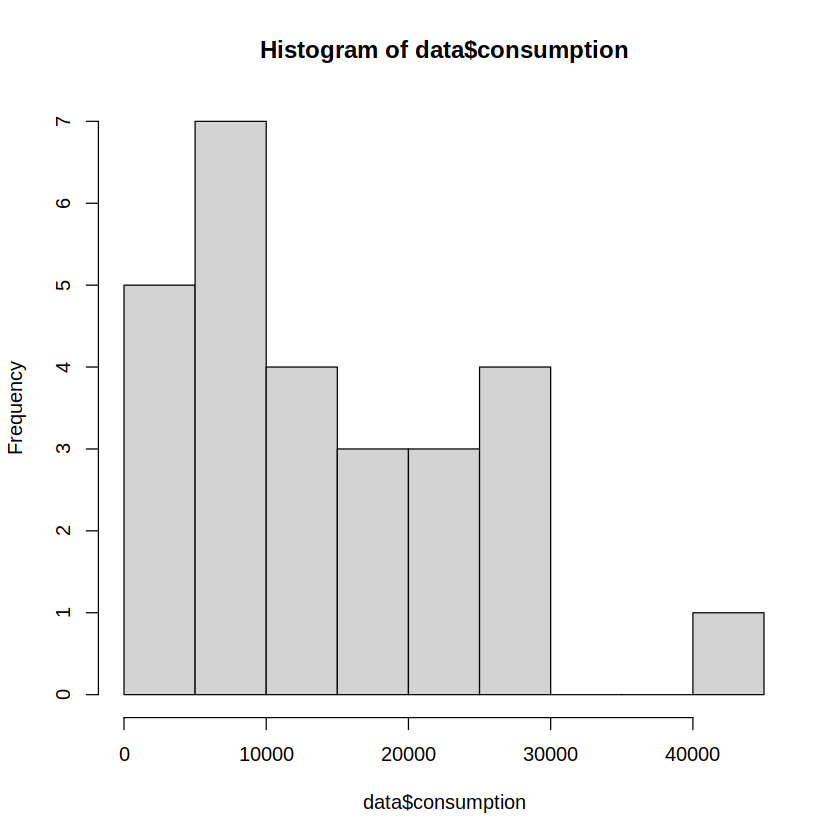

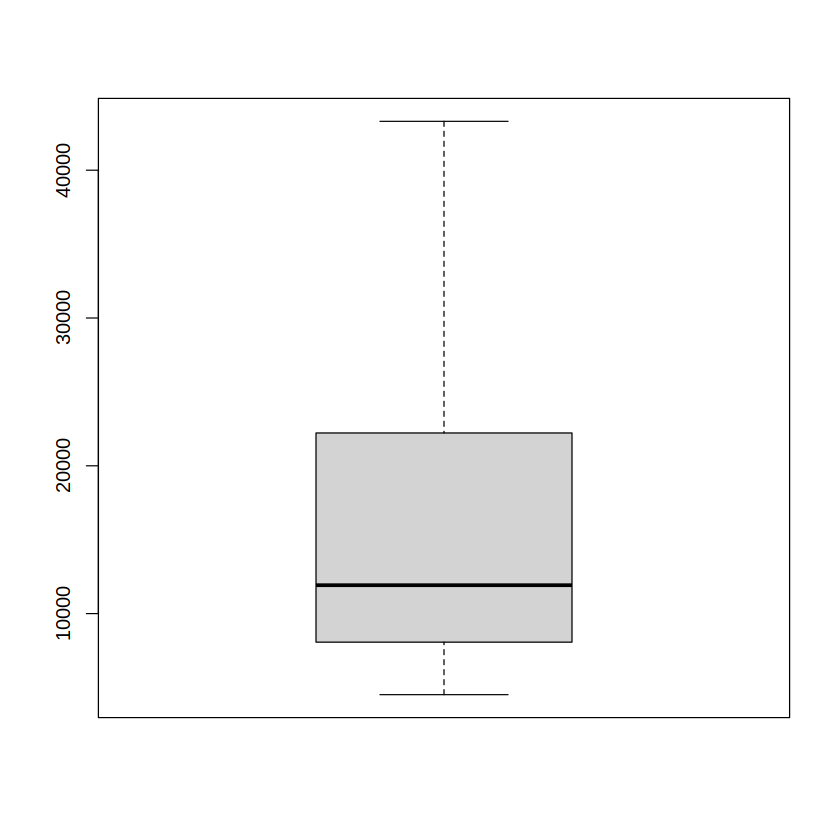

In [7]:
summary(data$consumption)

cat("\nVariance:", var(data$consumption))
cat("\nStandard dev:", sd(data$consumption))

hist(data$consumption)

boxplot(data$consumption)

Jak je vidět z výstupu výše, tak průměrné výdaje na jednoho obyvatele je 14 846 euro za rok. Minimum je 4 515 a maximum 43 306.

Je zajímavé, že tato veličina má relativně velkou směrodatnou odchylku - 9 677. Je to zhruba 68% průměrné hodnoty.

Je více zemí, ve kterých mají obytatelé spíše podprůměrné výdaje než nadprůměrné.

Vykreslíme si ještě graf závislosti HDP na této veličině.

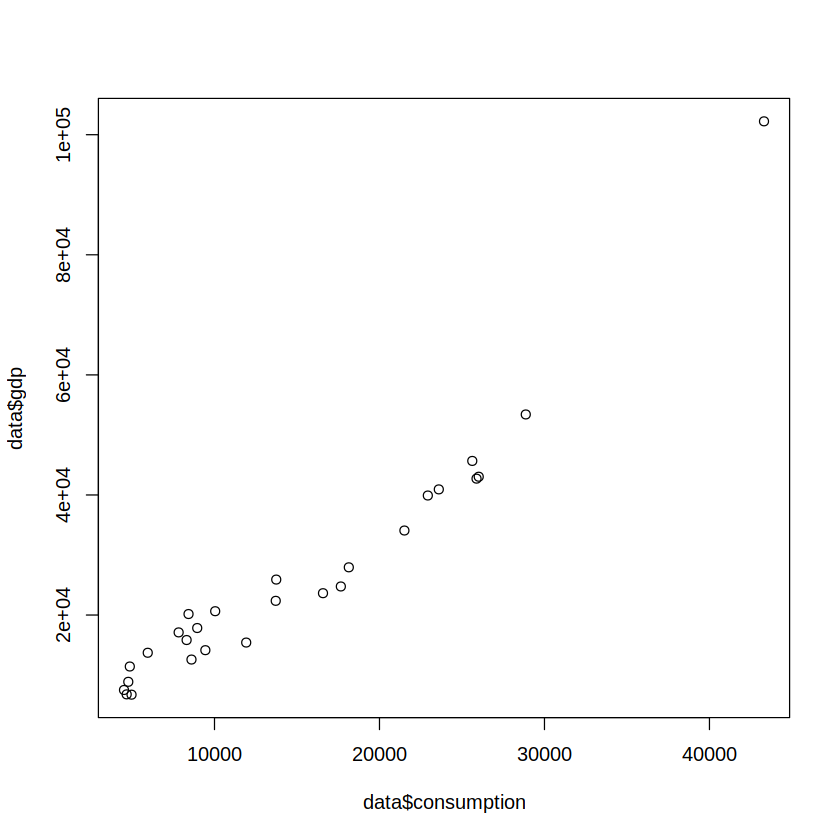

In [8]:
plot(data$consumption, data$gdp)

# ggplot(data, aes(x=consumption, y=gdp, color=uses_eur)) + geom_point() + theme_minimal()

Jak je vidět z grafu, tak HDP je vysoce korelované s průměrnými výdaji obyvatel.

In [9]:
model <- lm(data$gdp ~ 0 + data$consumption)
summary(model)


Call:
lm(formula = data$gdp ~ 0 + data$consumption)

Residuals:
    Min      1Q  Median      3Q     Max 
-7843.9 -4146.4 -1845.7   922.8 22269.3 

Coefficients:
                 Estimate Std. Error t value Pr(>|t|)    
data$consumption  1.84641    0.06306   29.28   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 5775 on 26 degrees of freedom
Multiple R-squared:  0.9706,	Adjusted R-squared:  0.9694 
F-statistic: 857.4 on 1 and 26 DF,  p-value: < 2.2e-16


Jak je vidět z výstupu výše, tak jestliže stoupne výdaj člověka o 1 euro, tak odhad HDP na jednoho člověka stoupne zhruba o 1.85 eura.

## Výdaje státu na obyvatele

V eurostatu jsme nikde nenašli výdaje státu přepočítané na jednoho obyvatele, takže si to spočítáme sami. Najdeme si nejdříve počet obyvatel a poté celkové výdaje daného státu.

Získání počtu obyvatel států v roce 2020:

https://ec.europa.eu/eurostat/databrowser/view/nama_10_pe/default/table?lang=en

In [10]:
pop <- get_eurostat("nama_10_pe")

pop <- pop[pop$unit == "THS_PER", ] # in thousands
pop <- pop[pop$TIME_PERIOD == as.Date("2020-01-01"), ]
pop <- pop[!grepl("^(EU|EA)", pop$geo), ]
pop <- pop[pop$na_item == "POP_NC", ] # inhabitants per country

pop$unit <- NULL
pop$freq <- NULL
pop$TIME_PERIOD <- NULL
pop$na_item <- NULL

pop$values <- pop$values * 1000

head(pop)

Table nama_10_pe cached at /tmp/Rtmpi26MSj/eurostat/4436acf1fe8ef369a41949c4574cf81d.rds



geo,values
<chr>,<dbl>
AL,2837850
AT,8916850
BE,11539000
BG,6934020
CH,8638170
CY,892000


výdaje státu celkem:

https://ec.europa.eu/eurostat/databrowser/view/gov_10a_main$defaultview/default/table?lang=en

In [11]:
ge <- get_eurostat("gov_10a_main")
ge <- ge[ge$unit == "MIO_EUR", ] # milions EUR
ge <- ge[ge$TIME_PERIOD == as.Date("2020-01-01"), ]
ge <- ge[ge$sector == "S13", ] # general government
ge <- ge[ge$na_item == "TE", ] # Total general government expenditure
ge <- ge[!grepl("^(EU|EA)", ge$geo), ]

ge$unit <- NULL
ge$freq <- NULL
ge$TIME_PERIOD <- NULL
ge$sector <- NULL
ge$na_item <- NULL

ge$values <- ge$values * 1000000

head(ge)

Table gov_10a_main cached at /tmp/Rtmpi26MSj/eurostat/b673bbe65b86fdb5807ff78d555f6e7c.rds



geo,values
<chr>,<dbl>
AT,216367000000
BE,271252900000
BG,25574400000
CH,249450700000
CY,9772900000
CZ,101900700000


Přepočet na obyvatele:

In [12]:
exp <- merge(ge, pop, by="geo", all=FALSE)
exp$ge_exp <- exp$values.x / exp$values.y

exp$values.x <- NULL
exp$values.y <- NULL

head(exp)

,geo,ge_exp
,<chr>,<dbl>
1,AT,24264.959
2,BE,23507.488
3,BG,3688.250
4,CH,28877.725
5,CY,10956.166
6,CZ,9523.288


Sloučení s daty o HDP:

In [13]:
data <- merge(data, exp, by="geo", all=FALSE)
data <- rename(data, gov_exp = ge_exp)

head(data)

,geo,gdp,consumption,gov_exp
,<chr>,<dbl>,<dbl>,<dbl>
1,AT,42720,25882,24264.959
2,BE,39910,22930,23507.488
3,BG,8880,4775,3688.250
4,CY,24760,17658,10956.166
5,CZ,20170,8426,9523.288
6,DE,40930,23596,20653.708


Důležité vlastnosti, veličiny a výdaje státu na jednoho obyvatele:

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
   3688    7448   10956   14144   20844   48008 


Variance: 99553530
Standard deviation: 9977.652

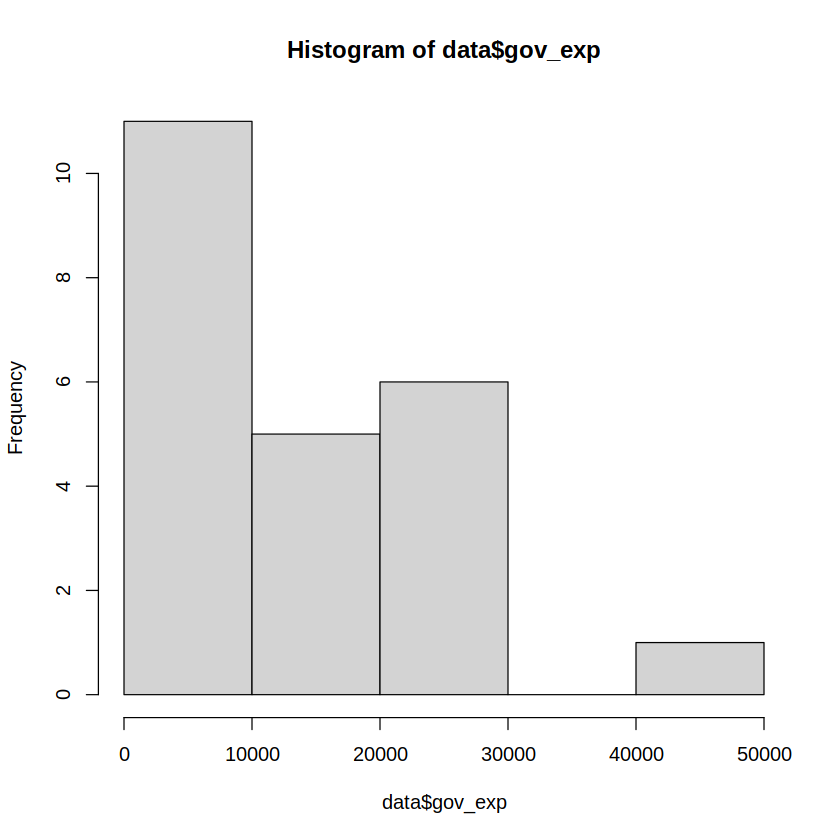

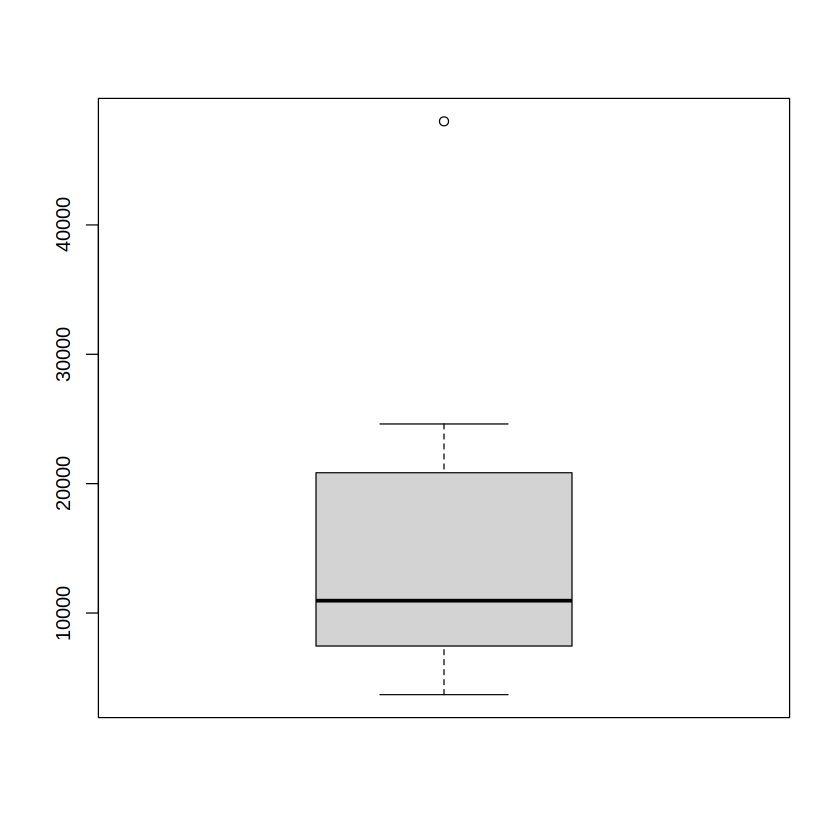

In [14]:
summary(data$gov_exp)

cat("\nVariance:", var(data$gov_exp))
cat("\nStandard deviation:", sd(data$gov_exp))

hist(data$gov_exp)
boxplot(data$gov_exp)

Jak je vidět z výstupu výše, tak průměrná hodnota výdaje státu na jednoho obyvatele je 14 144 euro na rok. Myslím si, že tento údaj je velice zajímavý.

V Česku průměrné výdaje jednoho člověka v roce 2020 bez nákladů na bydlení byly 8 426 euro. Stát ten rok měl výdaje v přepočtu na jednoho obyvatele 9 523,288 euro. Je ale nutné myslet na to, že v tomto roce byla pandemie, takže hodnoty budou nejspíše velice odlišné od normálního fungování státu.

I tato veličina má relativně velkou směrodatnou odchylku v poměru k průměrné hodnotě.

Opět je zde vidět, že je více států, ve kterých jsou výdaje na člověka menší než průměr než států, ve kterých je průměrné výdaje větší než průměr. Zároveň z boxplotu je vidět jeden outlier, který by mohl velice ovlivnit výsledky regrese.

Vykreslíme si znovu opět závislost HDP na této veličině:

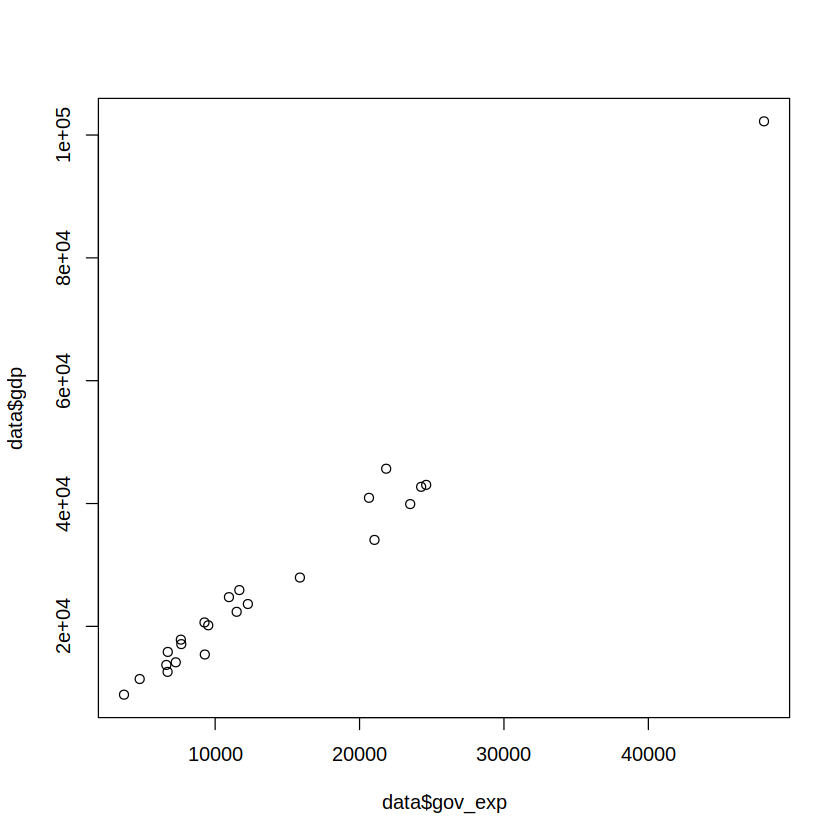

In [15]:
plot(data$gov_exp, data$gdp)

Z grafu výše je opět vidět velice silná korelace HDP a výdajů státu.

Korelační koeficient:

In [16]:
cor(data$gov_exp, data$gdp)

model <- lm(data$gdp ~ 0 + data$gov_exp)
summary(model)

[1] 0.9831386


Call:
lm(formula = data$gdp ~ 0 + data$gov_exp)

Residuals:
    Min      1Q  Median      3Q     Max 
-7209.5 -1690.6   727.7  2553.5  7991.5 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)    
data$gov_exp  1.96298    0.04391    44.7   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 3619 on 22 degrees of freedom
Multiple R-squared:  0.9891,	Adjusted R-squared:  0.9886 
F-statistic:  1998 on 1 and 22 DF,  p-value: < 2.2e-16


Z výstupu výše je vidět, že korelační koeficient je vysoký, tak jak jsme předpovídali z grafu.

Z jednoduchého modelu lineární regrese je vidět, že pokud stát má výdaje na jednoho člověka o 1 euro větší, tak HDP zhruba vzroste o 1.96 eura.

## Inflace

https://ec.europa.eu/eurostat/databrowser/view/tec00118/default/table?lang=en

In [17]:
inf <- get_eurostat("tec00118")

head(inf)

inf <- inf[inf$TIME_PERIOD == as.Date("2020-01-01"), ]
inf <- inf[!grepl("^(EU|EA)", inf$geo), ]

inf$unit <- NULL
inf$freq <- NULL
inf$TIME_PERIOD <- NULL
inf$coicop <- NULL

head(inf)

Table tec00118 cached at /tmp/Rtmpi26MSj/eurostat/24d43c0eedea4d65696b20383dc10b15.rds



freq,unit,coicop,geo,TIME_PERIOD,values
<chr>,<chr>,<chr>,<chr>,<date>,<dbl>
A,RCH_A_AVG,CP00,AL,2017-01-01,3.2
A,RCH_A_AVG,CP00,AL,2018-01-01,1.8
A,RCH_A_AVG,CP00,AL,2019-01-01,1.7
A,RCH_A_AVG,CP00,AL,2020-01-01,2.2
A,RCH_A_AVG,CP00,AL,2021-01-01,2.3
A,RCH_A_AVG,CP00,AL,2022-01-01,6.6


geo,values
<chr>,<dbl>
AL,2.2
AT,1.4
BE,0.4
BG,1.2
CH,-0.8
CY,-1.1


Spojení s daty o HDP:

In [18]:
data <- merge(data, inf, by="geo", all=FALSE)
data <- rename(data, inflation = values)

head(data)

,geo,gdp,consumption,gov_exp,inflation
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>
1,AT,42720,25882,24264.959,1.4
2,BE,39910,22930,23507.488,0.4
3,BG,8880,4775,3688.250,1.2
4,CY,24760,17658,10956.166,-1.1
5,CZ,20170,8426,9523.288,3.3
6,DE,40930,23596,20653.708,0.4


   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  -1.30   -0.05    0.40    0.80    1.30    3.70 

Variance: 1.88
Standard dev: 1.371131

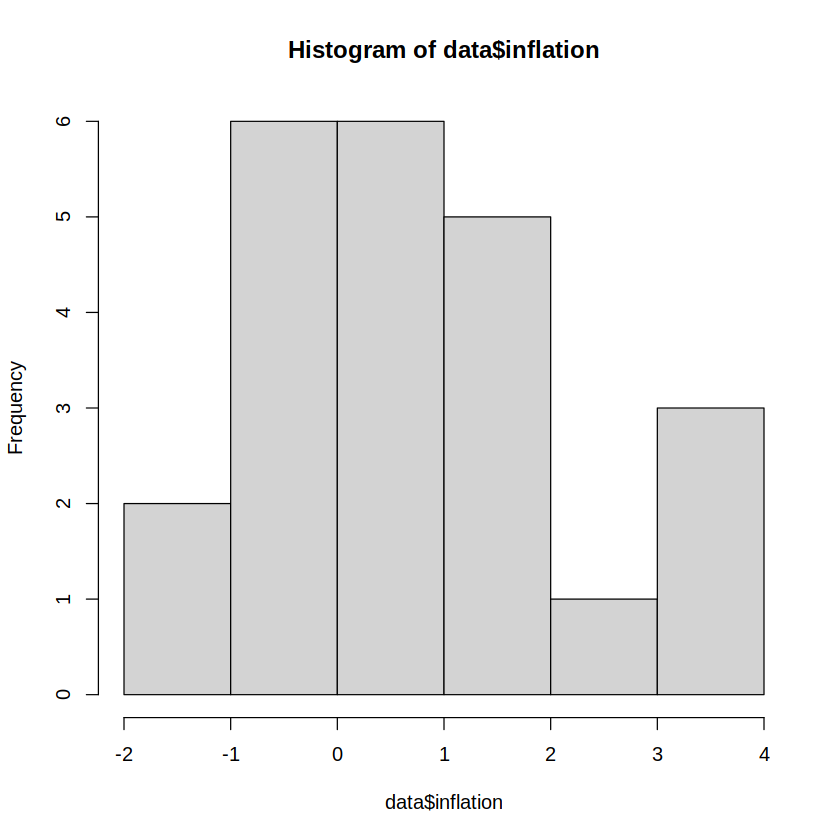

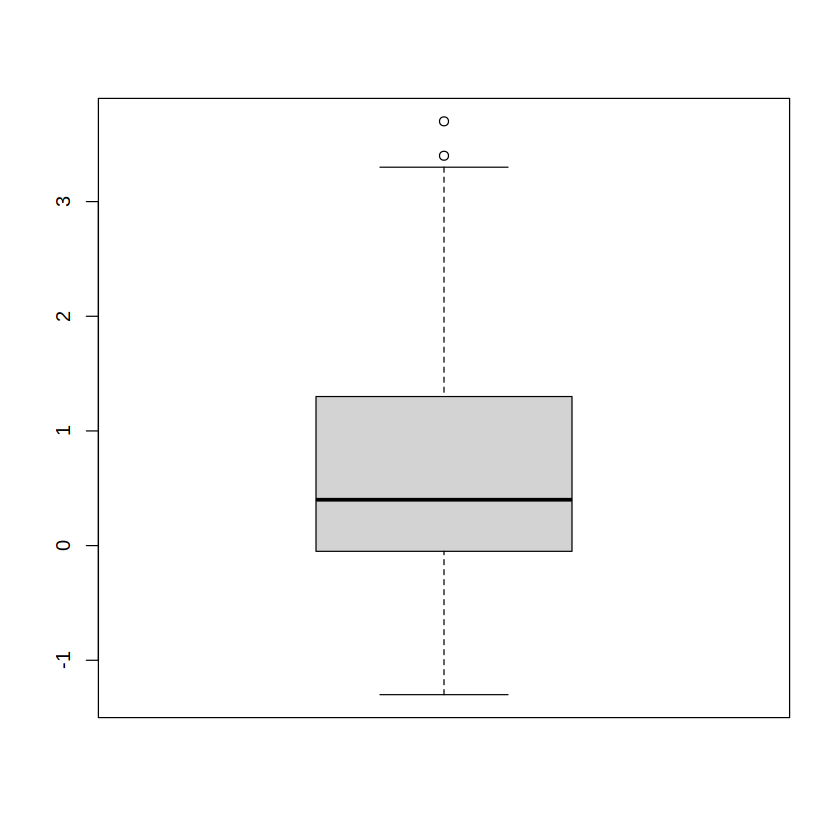

In [19]:
summary(data$inflation)

cat("Variance:", var(data$inflation))
cat("\nStandard dev:", sd(data$inflation))

hist(data$inflation)
boxplot(data$inflation)

Z výstupu výše je vidět, že průměrná inflace v roce 2020 byla 0.4%.

Zároveň je vidět, že minimum je -1.3%, to znamená, že nějaký stát byl v roce 2020 v deflaci. Tato hodnota je velice zajímavá v době pandemie.

Zobrazení závislosti HDP na inflaci a vypsání korelačního koeificientu:

[1] -0.2245871

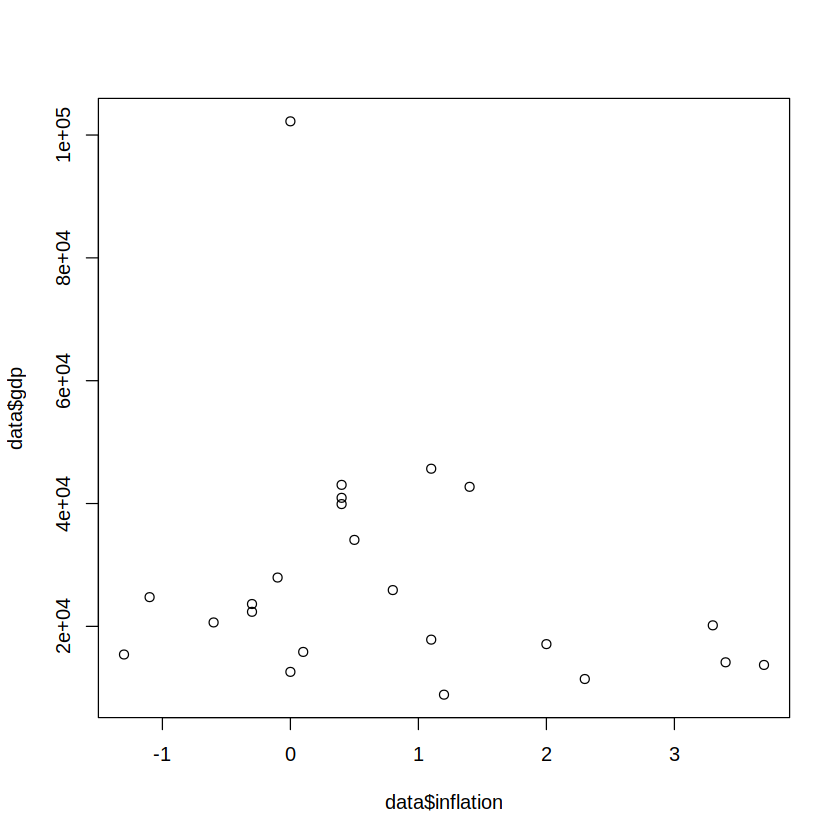

In [20]:
cor(data$inflation, data$gdp)

plot(data$inflation, data$gdp)

Z výstupu výše je vidět, že korelace mezi HDP a inflací není tak vysoká jako u předešlých veličin.

I tak ale tu nějaká je. Je zajímavé, že HDP klesá s rostoucí inflací. Očekával, že HDP bude stoupat s rostoucí inflací, protože produkty se pak prodávají za vyšší ceny a HDP roste.

Záporný korelační koeficient je kvůli tomu, že centrální banka reaguje na vysokou inflaci zvýšením úrokových sazeb a pro firmy i domácnosti je těžší existovat a tolik neutrácejí - takže se tolik ani nevyrábí.

## Indikátor EUR měny

Bohužel jsme nikde v eurostatu nenašli údaje o tom jaké země mají které měny, takže jsme si data museli najít sami jinde na internetu: 

In [21]:
eur <- data.frame(
  geo = c("AT", "BE", "BG", "CY", "CZ", "DE", "EE", "EL", "ES", "FI", "FR", "HR", "HU", "IT", "LT", "LU", "LV", "MT", "NL", "PL", "RO", "SI", "SK"),
  uses_eur = c(1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1)
)

eur$uses_eur <- ifelse(eur$uses_eur == 1, TRUE, FALSE)

head(eur)

,geo,uses_eur
,<chr>,<lgl>
1,AT,TRUE
2,BE,TRUE
3,BG,FALSE
4,CY,TRUE
5,CZ,FALSE
6,DE,TRUE


In [22]:
# data$geo
# eur$geo

Spojení s daty o HDP:

In [23]:
data <- merge(data, eur, by="geo", all=TRUE)

data

geo,gdp,consumption,gov_exp,inflation,uses_eur
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<lgl>
AT,42720,25882,24264.959,1.4,TRUE
BE,39910,22930,23507.488,0.4,TRUE
BG,8880,4775,3688.250,1.2,FALSE
CY,24760,17658,10956.166,-1.1,TRUE
CZ,20170,8426,9523.288,3.3,FALSE
DE,40930,23596,20653.708,0.4,TRUE
EE,20640,10042,9261.865,-0.6,TRUE
EL,15420,11922,9284.962,-1.3,TRUE
ES,23640,16576,12266.825,-0.3,TRUE


Důležité vlastnosti HDP v závislosti na měně:

EUR countries mean gdp: 32944.71
non EUR countries mean gdp: 13490

Number of countries with EUR: 

[1] 17  6

Number of countries without EUR: 

[1] 6 6

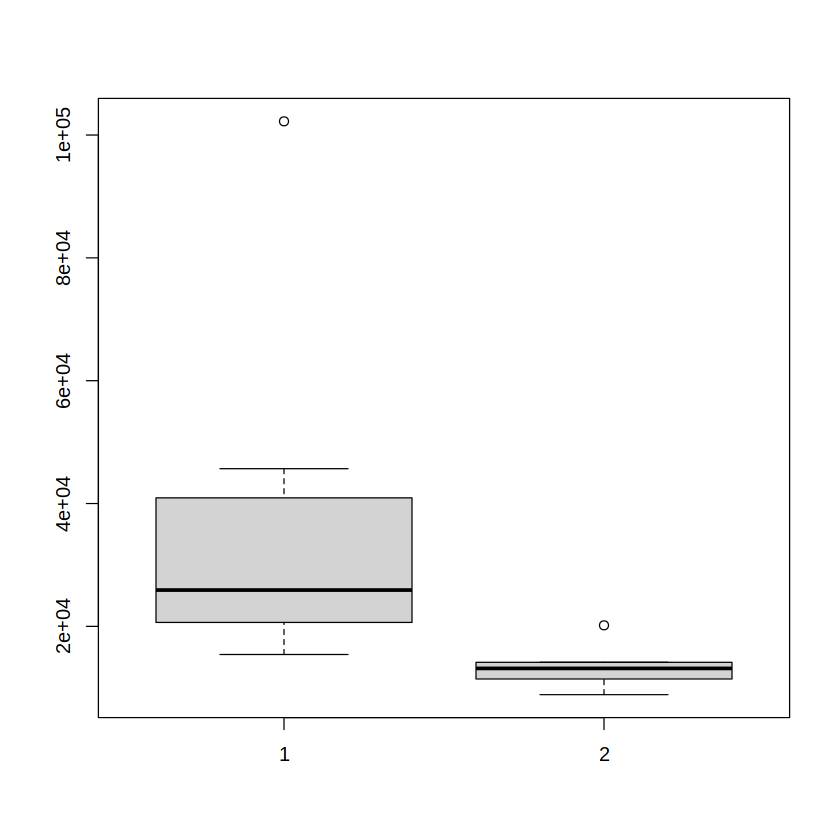

In [24]:
boxplot(data[data$uses_eur == TRUE, ]$gdp, data[data$uses_eur == FALSE, ]$gdp)

cat("EUR countries mean gdp:", mean(data[data$uses_eur == TRUE, ]$gdp))
cat("\nnon EUR countries mean gdp:", mean(data[data$uses_eur == FALSE, ]$gdp))

cat("\n\nNumber of countries with EUR: ")
dim(data[data$uses_eur == TRUE, ])

cat("Number of countries without EUR: ")
dim(data[data$uses_eur == FALSE, ])

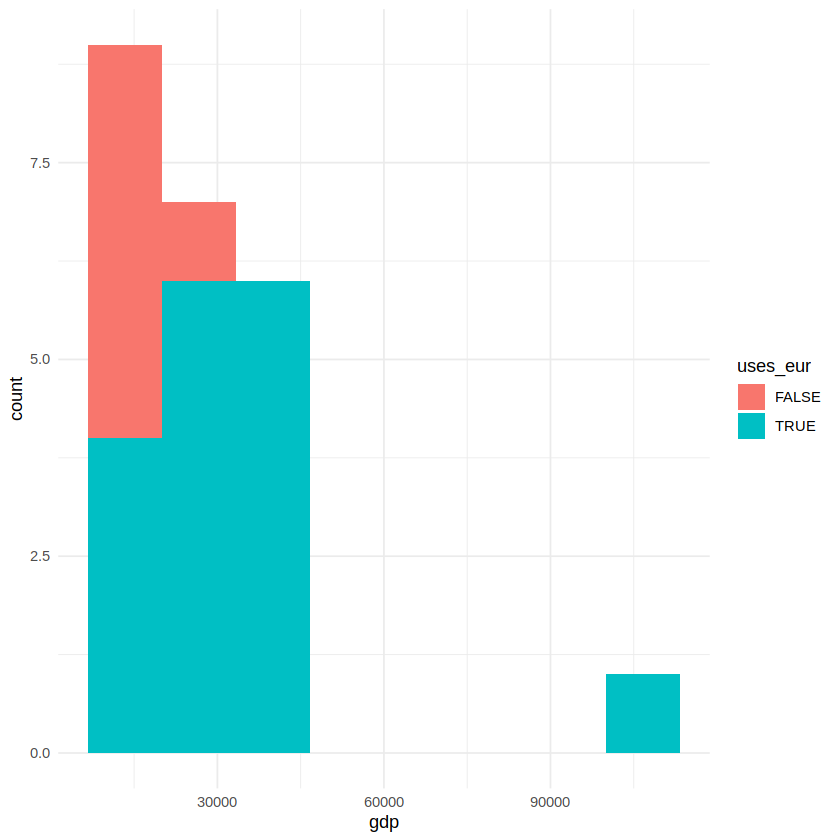

In [25]:
ggplot(data, aes(x=gdp, fill=uses_eur)) +
    geom_histogram(bins=8) +
    theme_minimal()

Jak je vidět z výstupu výše, tak země, které nemají euro mají významně nižší HDP. Zároveň ale nemáme moc dat. Máme údaje o 6 zemích, které nemají euro a o 17 zemích, které euro mají. Bohužel se nám ztratilo několik zemí, nejvíce kvůli chybějícím datům v tabulce o průměrných výdajích obyvatel.


chtěli bychom otestovat, zda střední hodnoty napříč kategoriemi mají rozdílnou střední hodnotu na standardní hladině významnosti proti oboustranné alternativě

H0: Eeur == Eneur<br>
Ha: Eeur != Eneur

Musíme nejdříve otestovat předpoklady anova testu:

Na standardní hladině významnosti musíme ověřit normalitu odchylek napříč kategoriemi - odchylky odhadneme pomocí reziduí a otestujeme jestli jsou z normálního rozdělení.

H0: Rezidua jsou z normálního rozdělení<br>
Ha: Rezidua nejsou z normálního rozdělení


<br>
<br>

Na standardní hladině významnosti musíme ještě ověřit homogenitu:

H0: Rezidua zemí s eurem a zemí bez eura mají stejný rozptyl.<br>
Ha: Rezidua zemí s eurem a zemí bez eura mají rozdílný rozptyl.

In [26]:
model <- lm(data$gdp ~ data$uses_eur)
shapiro.test(model$resid)

bartlett.test(data$gdp ~ data$uses_eur)


	Shapiro-Wilk normality test

data:  model$resid
W = 0.72001, p-value = 2.574e-05



	Bartlett test of homogeneity of variances

data:  data$gdp by data$uses_eur
Bartlett's K-squared = 10.735, df = 1, p-value = 0.001051


Na standardní hladině významnosti zamítáme obě nulové hypotézy.

Musíme tedy použít nějakou transformaci vysvětlované proměnné, tak aby předpoklad byl splněný - použijeme logaritmus vysvětlované proměnné:

In [27]:
model <- lm(log(data$gdp) ~ data$uses_eur)
shapiro.test(model$resid)

bartlett.test(log(data$gdp) ~ data$uses_eur)


	Shapiro-Wilk normality test

data:  model$resid
W = 0.93449, p-value = 0.1368



	Bartlett test of homogeneity of variances

data:  log(data$gdp) by data$uses_eur
Bartlett's K-squared = 2.036, df = 1, p-value = 0.1536


Zde už nulové hypotézy nezamítáme a může předpokládat, že platí předpoklady anova testu. Otestujeme tedy rovnost středních hodnot:

In [28]:
anova(aov(log(data$gdp) ~ data$uses_eur))

,Df,Sum Sq,Mean Sq,F value,Pr(>F)
,<int>,<dbl>,<dbl>,<dbl>,<dbl>
data$uses_eur,1,2.795830,2.7958300,13.79871,0.00128264
Residuals,21,4.254921,0.2026153,NA,NA


Na standardní hladině významnosti zamítáme nulovou hypotézu ve prospěch alternativy. Znamená to, že země, které mají euro, mají statisticky významně rozdílné HDP oproti zemím, které euro nemají.

# Rozdělení HDP

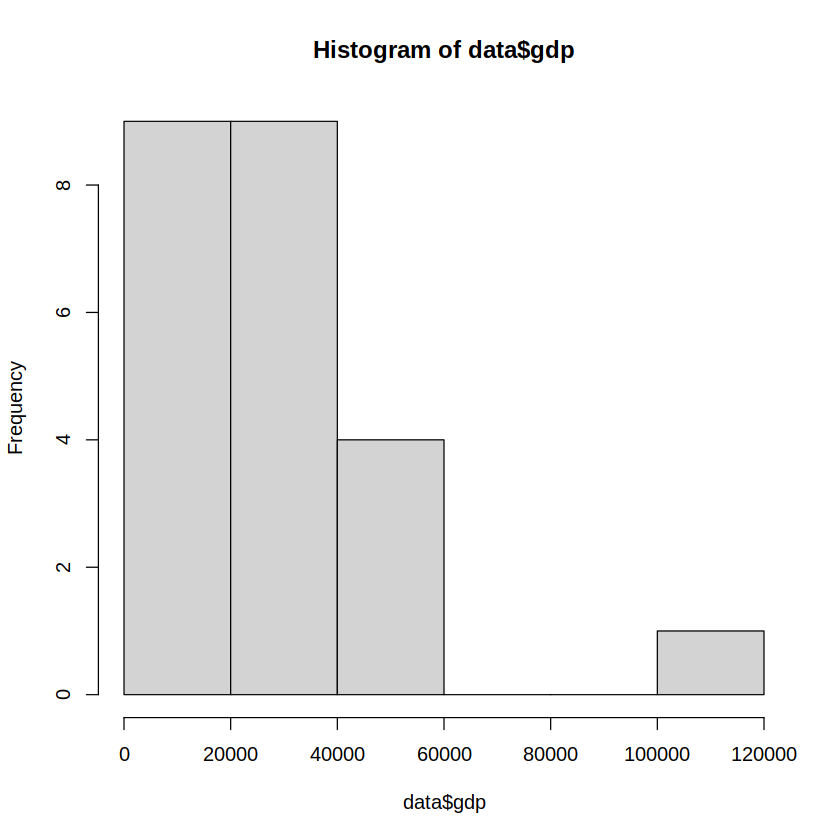

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
   8880   15630   22370   27870   36995  102230 


Var: 390597777
Standard dev.: 19763.55

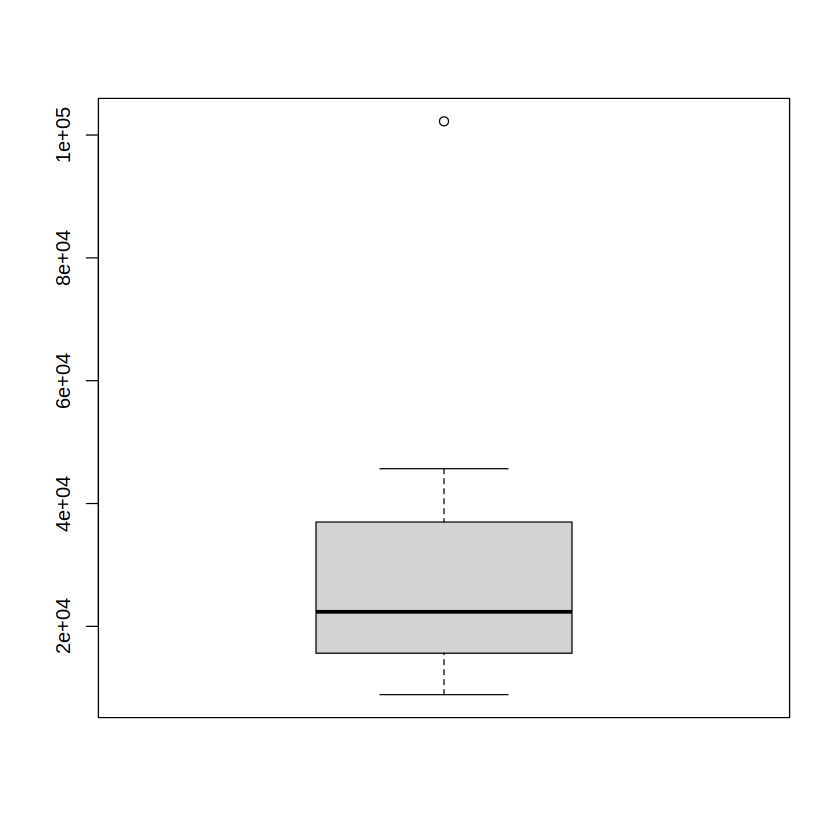

In [29]:
hist(data$gdp)

boxplot(data$gdp)

summary(data$gdp)

cat("\nVar:", var(data$gdp))
cat("\nStandard dev.:", sd(data$gdp))

Jak je vidět z výstpu výše, tak průměrná hodnota HDP na obyvatele je 27 870 euro (za rok). Standardní odchylka je relativně vysoké v poměru s poměrem - má hodnotu 19 763,55, což je zhruba 70% průměru. Zároveň je ale vidět z boxplotu, že tam je jeden outlier, kvůli kterému nejspíše bude tak vysoká směrodatná odchylka.

Tento outlier je pouze jeden a má hodnotu HDP na obyvatele 102 230, což je 3.67x více než průměr.

# Vztahy a závislosti jednotlivých veličin

vykreslení grafu závislosti jednotlivých veličin na ostatních veličinách:

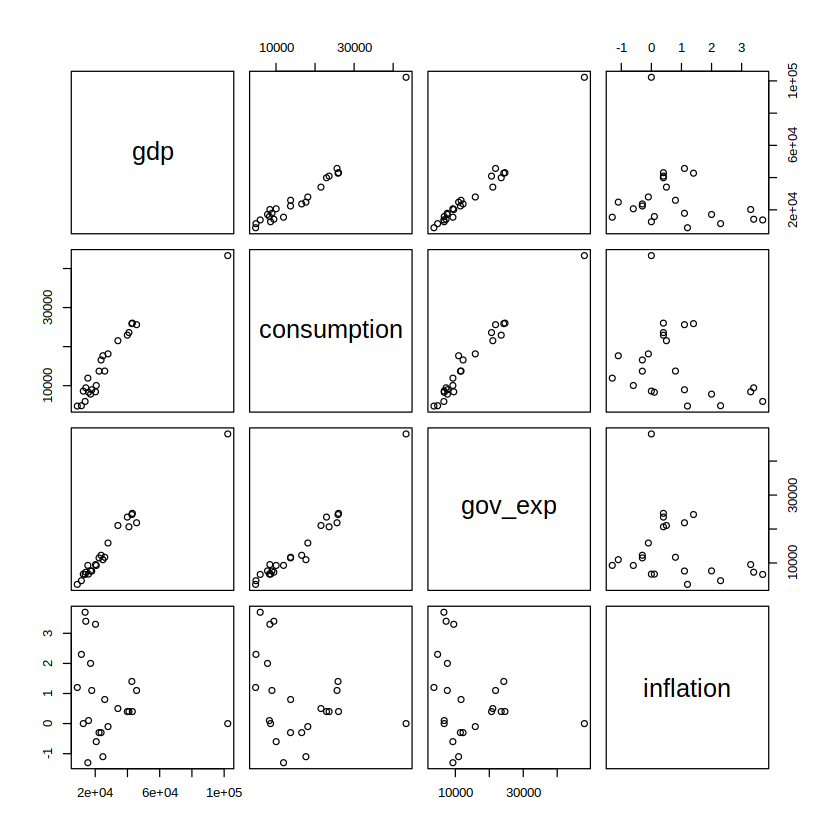

In [30]:
pairs(select_if(data, is.numeric))

Jak je vidět z grafu, tak HDP je vysoce korelované s consumption a government expenditure, jak jsme viděli dříve. 

Zároveň je ale vidět, že i výdaje vlády jsou vysoce korelované s výdaji obyvatel, takže bude možná lepší v modelu lineární regrese použít pouze jednu z těcho veličin.

Korelační koeficienty jednotlivých veličin:

In [31]:
cor(select_if(data, is.numeric))

,gdp,consumption,gov_exp,inflation
gdp,1.0000000,0.9532763,0.9831386,-0.2245871
consumption,0.9532763,1.0000000,0.9765340,-0.3467846
gov_exp,0.9831386,0.9765340,1.0000000,-0.2420767
inflation,-0.2245871,-0.3467846,-0.2420767,1.0000000


Pearsonův korelační koeficient předpokládá konečnou kovarianci a konečné rozptyly obou veličin. Myslím si, že pro představu a lineární závislosti je tento koeficient velice dobrý a není nutné testovat tyto předpoklady například tím, zda data pocházejí z normálního rozdělení.
 
I tak si můžeme zobrazit spearmanové koeficienty, které nemají takové předpoklady:

In [32]:
cor(select_if(data, is.numeric), method="spearman")

,gdp,consumption,gov_exp,inflation
gdp,1.0000000,0.9466403,0.9693676,-0.2454842
consumption,0.9466403,1.0000000,0.9584980,-0.3642668
gov_exp,0.9693676,0.9584980,1.0000000,-0.2776545
inflation,-0.2454842,-0.3642668,-0.2776545,1.0000000


Jak je vidět, tak koeficienty mají podobné hodnoty.

## Testy nulovosti korelačních koeficientů

Chtěli bychom otestovat, zda korelační koeficienty jednotlivých spojitých regresorů jsou statisticky význameně nulové na standardní hladině významnosti proti oboustranné alternativně. Budeme testovat nulovost spearmanových koeficientů, protože nepředpokládají konečnost kovariance a rozptylů.


H0: cor(gov_exp, consumption) == 0<br>
Ha: cor(gov_exp, consumption) != 0

In [33]:
cor.test(data$gov_exp, data$consumption, method="spearman")


	Spearman's rank correlation rho

data:  data$gov_exp and data$consumption
S = 84, p-value = 2.585e-06
alternative hypothesis: true rho is not equal to 0
sample estimates:
     rho 
0.958498 


Zde bychom zamítli nulovou hypotézu ve prospěch alternativy. Výdaje vlády na jednoho obyvatele jsou statisticky význameně korelované s průměrnými výdaji obyvatelů. Znamená to, že kdybychom použili oba regresory, tak lineární regrese nemusí být numericky stabilní a model by mohl obsahovat redundantní informaci.

Je zajímavé, jak moc souvisí výdaje státu s výdaji obyvatel.

In [34]:
cor.test(data$gov_exp, data$inflation, method="spearman")

Warning message in cor.test.default(data$gov_exp, data$inflation, method = "spearman"):
“Cannot compute exact p-value with ties”



	Spearman's rank correlation rho

data:  data$gov_exp and data$inflation
S = 2586, p-value = 0.1996
alternative hypothesis: true rho is not equal to 0
sample estimates:
       rho 
-0.2776545 


Zde bychom nulovou hypotézu nezamítli. Přidáním informace o inflaci do modelu lineární regrese dává smysl a nemusí představovat redundantní informaci.

In [35]:
cor.test(data$consumption, data$inflation, method="spearman")

Warning message in cor.test.default(data$consumption, data$inflation, method = "spearman"):
“Cannot compute exact p-value with ties”



	Spearman's rank correlation rho

data:  data$consumption and data$inflation
S = 2761.3, p-value = 0.08748
alternative hypothesis: true rho is not equal to 0
sample estimates:
       rho 
-0.3642668 


Zde bychom také nulovou hypotézu nezamítli.

Znamená to, že inflace není dostatečně vysvětlena výdaji obyvatel ani výdaji státu a nepředstavuje tedy redundantní informace.

# Regrese

In [36]:
ratio <- function(resid, gdp)
{
    cat("Mean resid size in ratio to gdp:", (mean(abs(resid) / gdp)) * 100, "%")
}

Kvůli vysoké korelaci mezi gov_exp a consumption může být problém kovariance a matice lineární regrese může být špatné podmíněná. I tak zkusíme nejdříve obyčejnou lineární regresi bez regularizace.

In [37]:
model <- lm(data$gdp ~ data$gov_exp + data$inflation + data$uses_eur + data$consumption)

summary(model)

ratio(model$resid, data$gdp)


Call:
lm(formula = data$gdp ~ data$gov_exp + data$inflation + data$uses_eur + 
    data$consumption)

Residuals:
    Min      1Q  Median      3Q     Max 
-7239.2 -2156.7   376.4  2192.1  7189.8 

Coefficients:
                   Estimate Std. Error t value Pr(>|t|)    
(Intercept)       1641.5812  2857.7758   0.574 0.572789    
data$gov_exp         2.2289     0.4499   4.954 0.000103 ***
data$inflation    -171.7149   869.9026  -0.197 0.845730    
data$uses_eurTRUE -717.1389  2883.6628  -0.249 0.806416    
data$consumption    -0.2976     0.5076  -0.586 0.564930    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 3928 on 18 degrees of freedom
Multiple R-squared:  0.9677,	Adjusted R-squared:  0.9605 
F-statistic: 134.7 on 4 and 18 DF,  p-value: 3.738e-13


Mean resid size in ratio to gdp: 9.688105 %

Jak je vidět z výstupu výše, tak obyčejná lineární regrese neměla zas tak velký problém s kovariancí mezi sloupci gov_exp a consumption. Koeficienty mají rozumné hodnoty. Myslím si, že v tomto případě není zas tak velký problém s numerickou stabilitou. Nicméně z výstupu výše je vidět, že nějaké koeficienty mají vysoké směrodatné odchylky.

Je zajímavé, že koeficient u consumption má zápornou hodnotu přestože korelační koeficient vysvětlované proměnnou s tímto regresorem byl zhruba 0.95. Nemyslím si, že to je špatnou podmíněností matice.

Přestože má HDP vysokou korelaci s gov_exp i consumption a zároveň má gov_exp vysokou korelaci s consumption, tak je vidět, že nejmenší reziduální součet čtverců je se záporným koeficientem u consumption.

Jak jsme viděli u lineární regrese při použití pouze consumption nebo pouze gov_exp, tak koeficienty v obou případech byly menší než 2. Je tedy vidět, že nejmenší RSS se dosahuje, pokud se odhad HDP "přestřelí" pomocí gov_exp (koeficient má hodnotu 2.23) a následně trochu sníží pomocí consumption (koeficient má hodnotu -0.3).

Z výstupu výše je vidět, že pokud se zvýší výdaj státu na obyvatele a rok o jedno euro, tak tento model bude predikovat o 2.23 eura větší HDP na obyvatele. Zároveň je ale nutné myslet na to, že čím vyšší je výdaj státu na obyvatele, tak tím vyšší nejspíše bude i výdaj obyvatel - takže výsledné zvýšení HDP bude zhruba pouze o 1.8 eura (2.23 - 0.3).

Zároveň pokud se inflace zvýší o jedno procento, tak tento model bude odhadovat nižší HDP na obyvatele o 171 euro.

Zároveň tento model bude odhadovat o 717 eur nižší HDP pokud daný stát má euro, což je zvláštní. Státy, které mají euro měli výrazně vyšší HDP.

Tento model je velmi dobrý. Hodnota R^2 je vysoká.

Jak jsme viděli dříve, tak tento model obsahuje skoro lineárně závislé regresory, takže prozkoumáme multikolinearitu a vyzkoušíme metody regularizace a indentifikace redundantních regresorů:

# Multikolinearita

## Hřebenová regrese

Zkusíme použít hřebenovou regresi, abychom se vypořádali se špatně podmíněnou maticí v lineární regresi.

In [38]:
models <- lm.ridge(data$gdp ~ data$inflation + data$uses_eur + data$consumption + data$gov_exp, lambda=seq(0, 100, 0.01))

select(models)

modified HKB estimator is 0.06420836 
modified L-W estimator is 0.08535865 
smallest value of GCV  at 0.07 


Jak je vidět z výstupu výše, tak ideální hodnota lambdy je 0.07. Je překvapivé, že přestože je kolinearita výrazná, tak optimální síla regularizace je relativně malá.

In [39]:
model <- lm.ridge(data$gdp ~ data$inflation + data$uses_eur + data$gov_exp + data$consumption, lambda=0.07)
model

                     data$inflation data$uses_eurTRUE      data$gov_exp 
    1128.98066706      -56.75116478     -912.13487734        2.04264417 
 data$consumption 
      -0.09198697 

Z výstupu výše je vidět, že koeficienty se změnili oproti normální lineární regresi. Je zajímavé, že keoficient u indentifikátoru, zda daná země má euro se ještě snížil. S rostoucí lambdou by se koeificienty měli být čím dál více přibližovat nule.

## VIF

Vyzkoušíme ještě vif k tomu, abychom našli regresory, které nenesou další důležité informace oproti ostatním.

In [40]:
model <- lm(data$gdp ~ data$uses_eur + data$consumption + data$inflation + data$gov_exp)

vif(model)

data$uses_eur data$consumption   data$inflation     data$gov_exp 
        2.389946        32.053520         2.028377        28.731515

Z výstupu výše je vidět, že pokud odebereme regresor consumption, tak model lineární regrese se výrazně nezhorší. Znamená to tedy, že consumption nese redundantní informaci. Jak jsme viděli dříve, tak consumption má vysokou korelaci s gov_exp a bude tedy lepší ji z modelu odebrat.

In [41]:
model <- lm(data$gdp ~ data$uses_eur + data$gov_exp + data$inflation)
vif(model)

data$uses_eur   data$gov_exp data$inflation 
      2.229889       1.299299       1.846355

Po odstranění consumption už v modelu není žádný příznak s hodnotou vif větší než 5, takže bychom nemusli odebírat další regresory z tohoto modelu z důvodu multikolinearity.

In [42]:
summary(model)

ratio(model$resid, data$gdp)


Call:
lm(formula = data$gdp ~ data$uses_eur + data$gov_exp + data$inflation)

Residuals:
    Min      1Q  Median      3Q     Max 
-7075.3 -2048.9   522.5  2780.0  7895.9 

Coefficients:
                    Estimate Std. Error t value Pr(>|t|)    
(Intercept)        8.581e+02  2.482e+03   0.346    0.733    
data$uses_eurTRUE -1.155e+03  2.737e+03  -0.422    0.678    
data$gov_exp       1.971e+00  9.401e-02  20.968 1.35e-14 ***
data$inflation    -1.892e+01  8.155e+02  -0.023    0.982    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 3860 on 19 degrees of freedom
Multiple R-squared:  0.9671,	Adjusted R-squared:  0.9619 
F-statistic: 185.9 on 3 and 19 DF,  p-value: 2.948e-14


Mean resid size in ratio to gdp: 10.18244 %

Jak je vidět z výstupu výše, tak R^2 i adj. R^2 se snížily s vynecháním regresoru consumption, ale pouze o tisíciny. Můžeme zde opět vidět, že regresor consumption opravdu nesl redundantní informaci.

# Odlehlá pozorování

graf cookových vzdáleností:

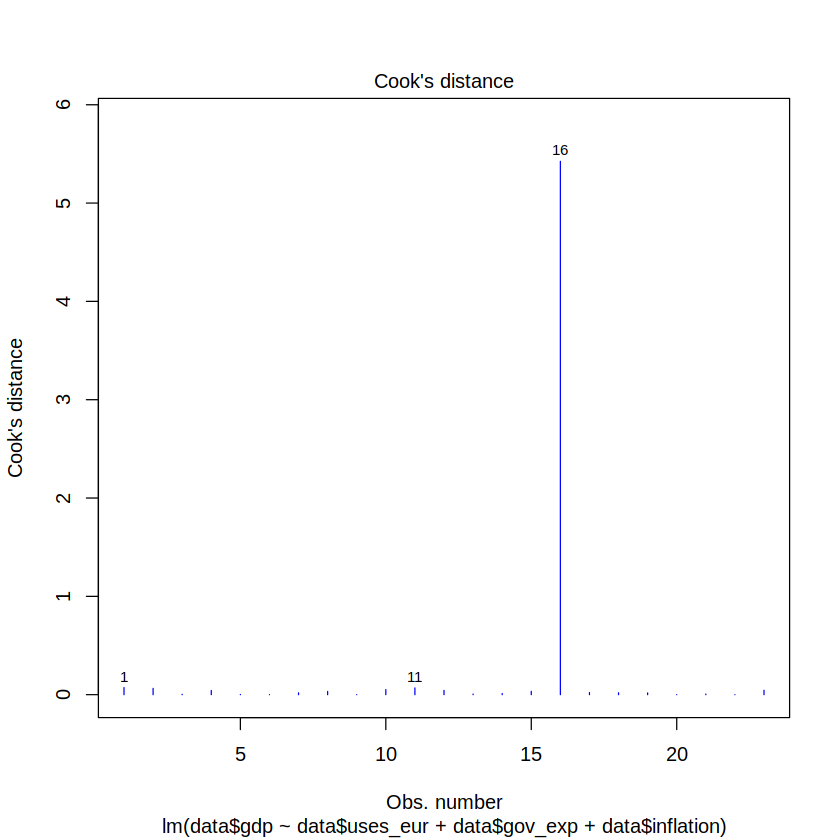

In [43]:
plot(model, which=4, col=c("blue"))

Jak je vidět z grafu, data obsahují jednoho outliera. Znamená to, že kdybychom vynechali tento datový bod, tak se odhady koeficientů v lienární regresy výrazně změní.

Průzkum outlieru:

Outlier:

,geo,gdp,consumption,gov_exp,inflation,uses_eur
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<lgl>
16,LU,102230,43306,48007.76,0,TRUE



With outlier:

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
   8880   15630   22370   27870   36995  102230 


Var: 390597777
Standard dev.: 19763.55

Data without outlier:

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
   8880   15525   21505   24490   32548   45670 


Var: 133920814
Standard dev.: 11572.42

Standard dev. is lowered by: 41.44565 %

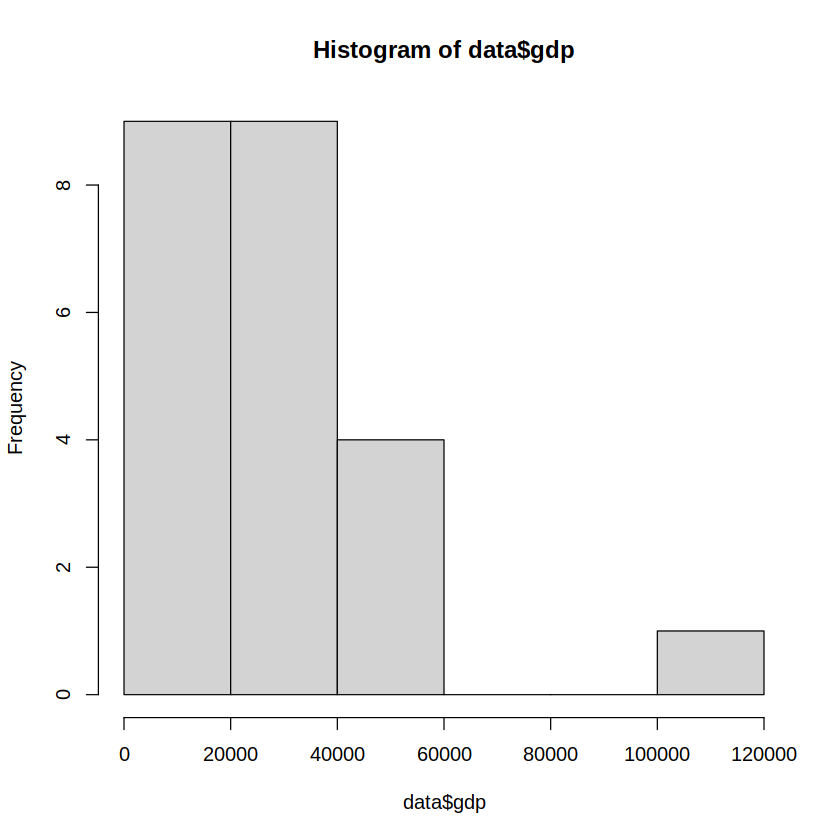

In [44]:
cat("Outlier:")
data[16, ]

cat("\nWith outlier:")
summary(data$gdp)
hist(data$gdp)
cat("\nVar:", var(data$gdp))
cat("\nStandard dev.:", sd(data$gdp))

subdata <- subset(data, rownames(data) != 16)

cat("\n\nData without outlier:")


summary(subdata$gdp)
cat("\nVar:", var(subdata$gdp))
cat("\nStandard dev.:", sd(subdata$gdp))
cat("\n\nStandard dev. is lowered by:", (sd(data$gdp) - sd(subdata$gdp)) / sd(data$gdp) * 100, "%")

Jak je vidět z výstupu výše, tak směrodatná odchylka HDP se výrazně sníží pokud vynecháme outliera, který je vidět v histogramu.

model lineární regrese bez outlieru:

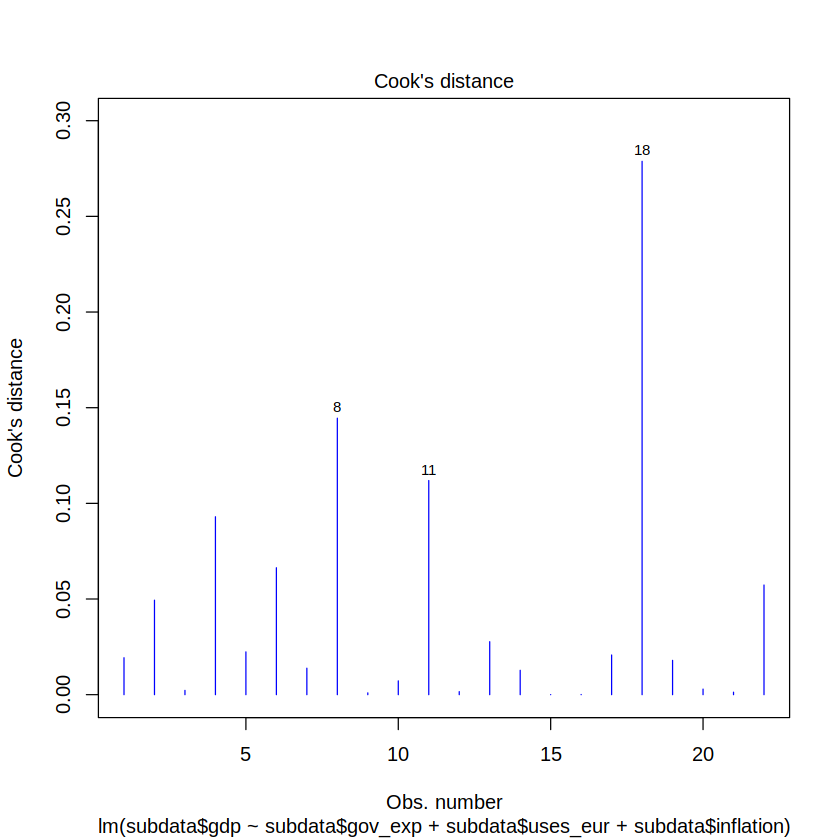

In [45]:
model <- lm(subdata$gdp ~ subdata$gov_exp + subdata$uses_eur + subdata$inflation)

plot(model, which=4, col=c("blue"))

Jak je vidět z výstupu výše, vynecháním tohoto outlieru v lineární regresi zajistí, že už zde žádní další outlieři nejsou.

In [46]:
summary(model)

cat("\n")
ratio(model$resid, subdata$gdp)


Call:
lm(formula = subdata$gdp ~ subdata$gov_exp + subdata$uses_eur + 
    subdata$inflation)

Residuals:
    Min      1Q  Median      3Q     Max 
-4181.6 -1279.6  -217.3  1057.4  5761.6 

Coefficients:
                      Estimate Std. Error t value Pr(>|t|)    
(Intercept)          1.992e+03  1.578e+03   1.262    0.223    
subdata$gov_exp      1.555e+00  9.657e-02  16.100 3.92e-12 ***
subdata$uses_eurTRUE 3.244e+03  1.904e+03   1.704    0.106    
subdata$inflation    6.477e+02  5.283e+02   1.226    0.236    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 2433 on 18 degrees of freedom
Multiple R-squared:  0.9621,	Adjusted R-squared:  0.9558 
F-statistic: 152.4 on 3 and 18 DF,  p-value: 5.563e-13



Mean resid size in ratio to gdp: 6.581443 %

# Předpoklady lineární regrese

Lineární regrese má několik předpokladů:

- Matice X neobsahuje lineární závislé sloupce - problém multikolinearity jsme prozkoumali už dříve
- odchylky jsou nezávislé a stejně rozdělené - otestujeme normalitu reziduí

Chtěli bychom otestovat normalitu reziduí na standardní hladině významnosti:

H0: Rezidua jsou z normálního rozdělení<br>
Ha: Rezidua nejsou z normálního rozdělení

In [47]:
model <- lm(data$gdp ~ data$inflation + data$uses_eur + data$consumption + data$gov_exp)

shapiro.test(model$resid)


	Shapiro-Wilk normality test

data:  model$resid
W = 0.97204, p-value = 0.7377


Na standardní hladině významnosti bychom nezamítli nulovou hypotézu. Můžeme tedy předpokládat, že odchylky jsou stejně rozdělené a platí tedy předpoklady modelu lineární regrese.

# Výběr finálního modelu

Budeme vybírat nejlepší model na základě AIC kritéria, které nám zajistí výběr optimálního modelu s optimálním počtem regresorů.

AIC kritérium stojí na tom, že odchylky jsou normálně rozdělené.

Budeme postupně odebírat regresory, dokud nebudeme mít nejlepší model.

Budeme i zároveň testovat normalitu reziduí na standardní hladině významnosti:

H0: rezidua mají normální rozdělení<br>
Ha: rezidua nemají normální rozdělení

In [48]:
model <- lm(data$gdp ~ (data$gov_exp + data$consumption + data$inflation) + data$uses_eur)
shapiro.test(model$resid)

drop1(model,test="F")


	Shapiro-Wilk normality test

data:  model$resid
W = 0.97204, p-value = 0.7377


,Df,Sum of Sq,RSS,AIC,F value,Pr(>F)
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
<none>,NA,NA,277744645,385.0545,NA,NA
data$gov_exp,1,378712067.7,656456713,402.8381,24.54346946,0.0001025402
data$consumption,1,5304779.8,283049425,383.4897,0.34379074,0.5649304684
data$inflation,1,601240.1,278345885,383.1043,0.03896501,0.8457299368
data$uses_eur,1,954312.9,278698958,383.1334,0.06184686,0.8064157168


Nezamítáme nulovou hypotézu, že rezidua mají normální rozdělení, takže můžeme použít AIC kritérium.

Z výstupu výše je vidět, že můžeme vynechat regresor inflation.

In [49]:
model <- lm(data$gdp ~ data$gov_exp + data$consumption + data$uses_eur)
shapiro.test(model$resid)

drop1(model, test="F")


	Shapiro-Wilk normality test

data:  model$resid
W = 0.97161, p-value = 0.7274


,Df,Sum of Sq,RSS,AIC,F value,Pr(>F)
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
<none>,NA,NA,278345885,383.1043,NA,NA
data$gov_exp,1,410068973.0,688414858,401.9314,27.99146995,4.170528e-05
data$consumption,1,4711559.7,283057445,381.4903,0.32161292,5.772794e-01
data$uses_eur,1,449337.9,278795223,381.1414,0.03067198,8.628271e-01


In [50]:
model <- lm(data$gdp ~ data$gov_exp + data$consumption)

shapiro.test(model$resid)

drop1(model, test="F")


	Shapiro-Wilk normality test

data:  model$resid
W = 0.96587, p-value = 0.5912


,Df,Sum of Sq,RSS,AIC,F value,Pr(>F)
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
<none>,NA,NA,278795223,381.1414,NA,NA
data$gov_exp,1,505453086,784248309,402.9291,36.2598096,6.908322e-06
data$consumption,1,8546851,287342074,379.8359,0.6131275,4.427865e-01


Pomocí anova testu jsme dospěli k finálnímu modelu s pouze jedním regresorem - government expenditure

In [51]:
final_model = lm(data$gdp ~ data$gov_exp)
summary(final_model)


Call:
lm(formula = data$gdp ~ data$gov_exp)

Residuals:
    Min      1Q  Median      3Q     Max 
-7207.0 -1891.5   505.2  2352.4  8414.8 

Coefficients:
              Estimate Std. Error t value Pr(>|t|)    
(Intercept)  3.257e+02  1.358e+03    0.24    0.813    
data$gov_exp 1.947e+00  7.904e-02   24.64   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 3699 on 21 degrees of freedom
Multiple R-squared:  0.9666,	Adjusted R-squared:  0.965 
F-statistic:   607 on 1 and 21 DF,  p-value: < 2.2e-16


Jak je vidět z výstupů výše, tak pomocí AIC kritéria i pomocí Anova testů jsme došli ke stejnému finálnímu modelu, který obsahuje pouze jeden regresor - výdaje státu přepočítáné na obyvatele.

Koeficient R^2 hodnotí kvalitu daného modelu oproti modelu, který predikuje pouze průměr. Říká nám kolik variability bylo vysvětleno průměrem oproti našemu modelu, který používá více regresorů.

Tento model je velice dobrý - R^2 = 0,9666 a i adjustovaný R^2 je velmi vysoký. Zároveň to říká, že tento model má 30x menší rezidua, než model, který by pouze předpovídal průměr (1 / (1 - R^2)).

Zároveň je vidět z výstupu výše, že v průměru je reziduum zhruba 10% HDP, takže tento model je přesný. Dalo by se říct, že dokáže odhadnout HDP v průměru s přesnosti +-10%. Myslím si, že tento výsledek je velice dobrý když vezmeme v potaz, že používá pouze jeden regresor a směrodatná odchylka HDP byla 70% průměrné hodnoty.

Nulovost koeficientu u výdajů státu bychom zamítli na standardní hladině významnosti. Je ale zajímavé, že nulovost interceptu bychom nezamítli, přestože má hodnotu 325,7. Intercept z modelu nemá smysl odstraňovat, protože nám zajišťuje nestrannost odhadů.

Státům, které nemají vůbec žádné výdaje by odhadl HDP 325,7 euro na obyvatele za rok. S každým státem utraceným eurem na obyvatele navíc by tento model odhadl o 1,947 euro větší HDP.

Malá p hodnota F statistiky (poslední řádek summary) značí, že náš model je statisticky významný a alespoň jeden regresor souvisí s vysvětlovanou proměnnou.

Z výstupu výše je také vidět to, že residua mají kladný medián. Minimum je -7 207 -> to znamená, že model predikoval nějakou hodnotu nejvíce o 7 207 méně než byla skutečnost. Naopak maximum je 8 414 -> model predikoval nějaké zemi nejvíce o 8 414 větší HDP, než byla skutečnost.

Warning message in predict.lm(final_model, interval = "prediction"):
“predictions on current data refer to _future_ responses
”


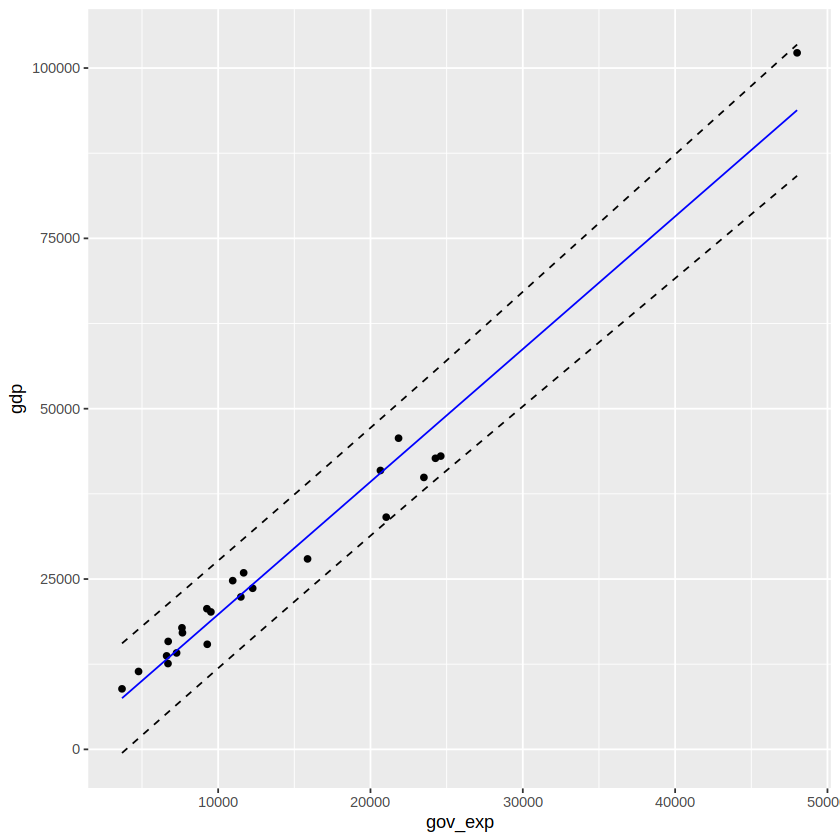

In [53]:
tmp <- predict(final_model, interval="prediction")
tmp <- cbind(data, tmp)

ggplot(tmp, aes(x=gov_exp, y=gdp)) +
    geom_point() +
    geom_line(aes(y=fit), color="blue") +
    geom_line(aes(y=lwr), color = "black", linetype = "dashed") +
    geom_line(aes(y=upr), color = "black", linetype = "dashed")